In [1]:
!uname -a
!g++ --version
!nvidia-smi
!nvcc --version || echo "No nvcc yet (enable GPU runtime later)"

Linux 20332f129752 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
g++ (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Wed Feb 11 12:00:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+=======

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


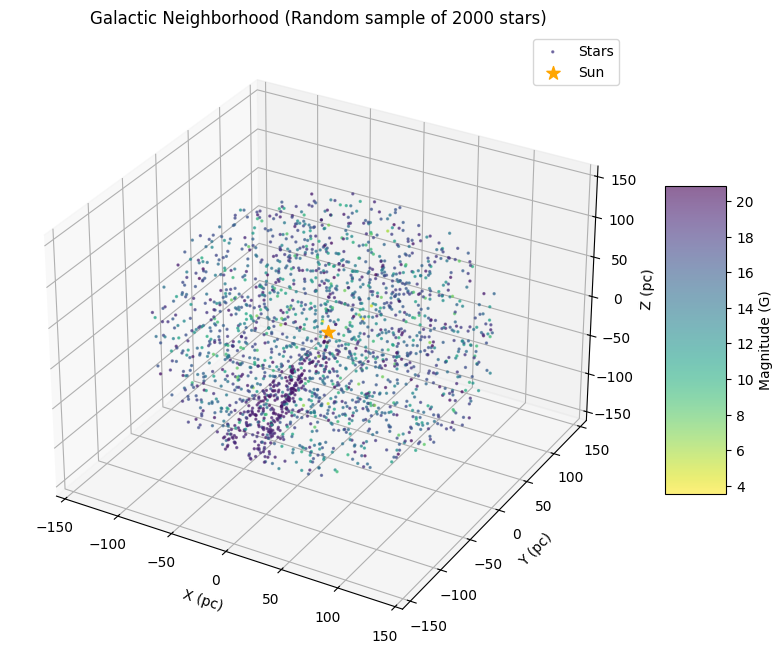

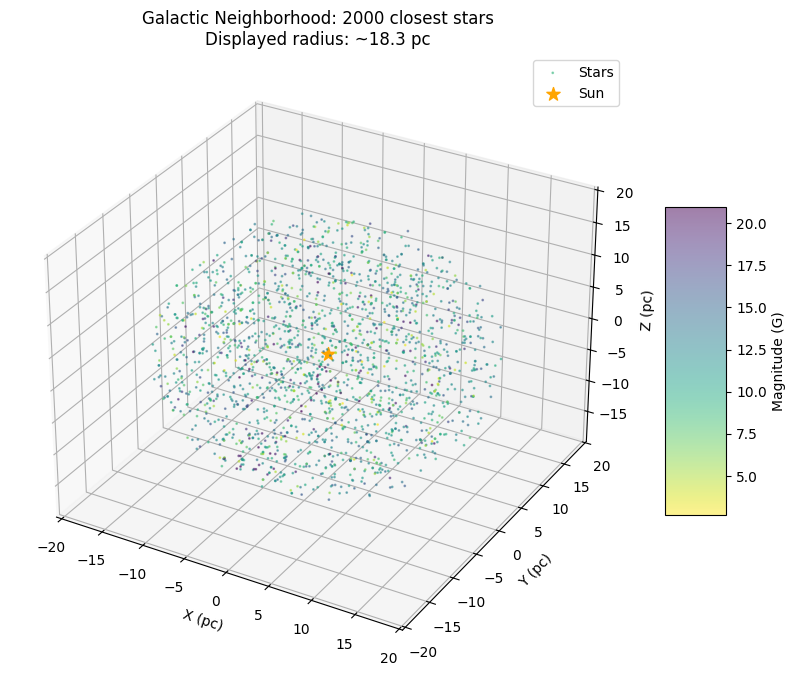

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the dataset
GAIA_CARTESIAN_FILENAME = 'GAIA_DR3_Cartesian_Heliocentric.csv'
gaia_cartesian_df = pd.read_csv("/content/drive/MyDrive/PDPProject/" + GAIA_CARTESIAN_FILENAME)

def plot_gaia_3d(df, title, output_file, point_size=2, alpha=0.6):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot stars
    # Using magnitude for color (lower magnitude = brighter)
    # Handling NaN in magnitude just in case, though usually GAIA data is clean enough in subsets
    sc = ax.scatter(
        df['x'], df['y'], df['z'],
        c=df['phot_g_mean_mag'],
        cmap='viridis_r',
        s=point_size,
        alpha=alpha,
        label='Stars'
    )

    # Sun
    ax.scatter([0], [0], [0],
               color='orange', s=100, marker='*', label='Sun')

    ax.set_xlabel('X (pc)')
    ax.set_ylabel('Y (pc)')
    ax.set_zlabel('Z (pc)')
    ax.set_title(title)

    # Add colorbar for magnitude
    cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Magnitude (G)')

    ax.legend()
    plt.show()
    #plt.savefig(output_file, dpi=150)
    #plt.close()

    #print(f"Plot saved to {output_file}")

def plot_random_gaia_neighborhood(df, subset_size):
    df_sample = (
        df.sample(n=subset_size, random_state=42)
        if len(df) > subset_size else df
    )

    title = f'Galactic Neighborhood (Random sample of {len(df_sample)} stars)'
    output_file = f'GAIA_random_neighborhood_{subset_size}.png'

    plot_gaia_3d(df_sample, title, output_file, point_size=2, alpha=0.6)

def plot_nearest_stars(df, subset_size):
    df = df.copy()
    df['distance_from_sun'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

    df_subset = (
        df.nsmallest(subset_size, 'distance_from_sun')
        if len(df) > subset_size else df
    )

    max_radius = df_subset['distance_from_sun'].max()

    title = (
        f'Galactic Neighborhood: {len(df_subset)} closest stars\n'
        f'Displayed radius: ~{max_radius:.1f} pc'
    )
    output_file = f'GAIA_nearest_{subset_size}.png'

    plot_gaia_3d(df_subset, title, output_file, point_size=1, alpha=0.5)

plot_random_gaia_neighborhood(gaia_cartesian_df, 2000)
plot_nearest_stars(gaia_cartesian_df, 2000)
# plot_random_gaia_neighborhood(gaia_cartesian_df, 20000)
# plot_nearest_stars(gaia_cartesian_df, 20000)
# plot_random_gaia_neighborhood(gaia_cartesian_df, 200000)
# plot_nearest_stars(gaia_cartesian_df, 200000)

In [55]:
%%writefile dbscan.cpp
#include <iostream>
#include <list>
#include <cmath>
#include <fstream>
#include <sstream>
#include <string>

using namespace std;

struct Star {
    double x;
    double y;
    double z;
    int label = -1; // -2 = visited, -1 = undefined, 0 = noise, 1, 2, 3... = cluster
};

// Anche questa è parallelizzabile
double squaredDistance(const Star& star1, const Star& star2) {
    double dx = star1.x - star2.x;
    double dy = star1.y - star2.y;
    double dz = star1.z - star2.z;
    return dx*dx + dy*dy + dz*dz;
}

// Si può parallelizzare a parte
list<Star*> rangeQuery(list<Star>& stars, const Star& star, double eps) {
    list<Star*> neighbors;
    for (Star& s : stars) {
        if (squaredDistance(star, s) <= eps*eps) { // Confronto con eps*eps per evitare sqrt
            neighbors.push_back(&s); // <- Puntatore all'oggetto originale
        }
    }
    return neighbors;
}

/*
    minPts conta anche il punto stesso
    eps (epsilon) è il raggio di vicinato del DBSCAN
*/
void dbscan(list<Star>& stars, double eps, int minPts) {
    int clusters = 0;
    for (Star& star : stars) { // <- Riferimento
        if (star.label == -1) {
            list<Star*> neighbors = rangeQuery(stars, star, eps);
            if (neighbors.size() < minPts) {
                star.label = 0;
            } else {
                clusters++;

                //cout << "Epstein " + to_string(clusters) << endl;

                star.label = clusters;
                list<Star*> seedSet = neighbors;
                for (auto it = seedSet.begin(); it != seedSet.end(); ++it) {
                    Star* neighbor = *it;
                    if (neighbor->label == 0) {
                        neighbor->label = clusters;
                    }
                    if (neighbor->label == -1) { //
                        neighbor->label = clusters;
                        list<Star*> neighbors2 = rangeQuery(stars, *neighbor, eps);
                        if (neighbors2.size() >= minPts) {
                            for (Star* n2 : neighbors2) {
                                if (n2->label == -1) {   // FIX CHIAVE: evita duplicati ed espansioni multiple
                                    n2->label = -2;
                                    seedSet.push_back(n2);
                                }
                            }

                            //seedSet.insert(seedSet.end(), neighbors2.begin(), neighbors2.end());
                        }
                    }
                }
            }
        }
    }
}

// Forse si può fare così: CPU prende una stella --> rangeQuery su quella stella parallelo

// ============ Lettura CSV ============

list<Star> loadCSV(const string& filename) {
    list<Star> stars;
    ifstream file(filename);
    if (!file.is_open()) {
        cerr << "Errore: impossibile aprire " << filename << endl;
        return stars;
    }
    string line;
    getline(file, line); // salta header (source_id,x,y,z,phot_g_mean_mag)

    while (getline(file, line)) {
        stringstream ss(line);
        string token;
        getline(ss, token, ','); // source_id -> ignora
        Star star;
        getline(ss, token, ','); star.x = stod(token);
        getline(ss, token, ','); star.y = stod(token);
        getline(ss, token, ','); star.z = stod(token);
        // phot_g_mean_mag -> ignora
        stars.push_back(star);
    }
    return stars;
}

int main() {
    // Carica dataset
    string GAIA_CARTESIAN_FILENAME = "GAIA_nearest_10000.csv";
    list<Star> stars = loadCSV("/content/drive/MyDrive/PDPProject/" + GAIA_CARTESIAN_FILENAME);
    cout << "Stelle caricate: " << stars.size() << endl;

    if (stars.empty()) return 1;

    // Esegui DBSCAN (eps e minPts da calibrare)
    double eps = 2;
    int minPts = 5;
    cout << "Eseguo DBSCAN con eps=" << eps << ", minPts=" << minPts << " ..." << endl;
    dbscan(stars, eps, minPts);

    // Conta risultati
    int noise = 0, maxCluster = 0;
    for (const auto& s : stars) {
        if (s.label == 0) noise++;
        if (s.label > maxCluster) maxCluster = s.label;
    }
    cout << "Cluster trovati: " << maxCluster << endl;
    cout << "Punti rumore: " << noise << " / " << stars.size() << endl;

    return 0;
}

Overwriting dbscan.cpp


In [56]:
!nvcc -O3 dbscan.cpp -o dbscan

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [57]:
!./dbscan

Stelle caricate: 10000
Eseguo DBSCAN con eps=2, minPts=5 ...
Cluster trovati: 896
Punti rumore: 4439 / 10000


In [ ]:
%%writefile dbscan2.cpp
#include <vector>
#include <queue>
#include <cmath>
#include <iostream>
#include <fstream>
#include <sstream>
#include <string>
#include <list>

using namespace std;

// ================= STAR =================
struct Star {
    double x;
    double y;
    double z;
    int label = -1; // -1 = undefined, 0 = noise, 1+ = cluster id
};

// ================= NAIVE DBSCAN =================
class NaiveDBSCAN {
public:
    NaiveDBSCAN(double eps, int minPts)
        : eps_(eps), eps_sq_(eps * eps), minPts_(minPts) {}

    void fit(std::vector<Star>& stars) {
        int n = stars.size();

        int cluster_id = 1; // 0 = noise

        std::vector<bool> visited(n, false);

        for (int i = 0; i < n; i++) {

            if (visited[i]) continue;

            visited[i] = true;

            auto neighbors = regionQuery(stars, i);

            if ((int)neighbors.size() < minPts_) {
                stars[i].label = 0; // noise
            } else {
                expandCluster(stars, visited, i, neighbors, cluster_id);
                cluster_id++;
            }
        }

        std::cout << "Clusters found: " << (cluster_id - 1) << std::endl;
    }

private:
    double eps_;
    double eps_sq_;
    int minPts_;

    // distanza quadrata 3D
    double dist_sq(const Star& a, const Star& b) const {
        double dx = a.x - b.x;
        double dy = a.y - b.y;
        double dz = a.z - b.z;
        return dx*dx + dy*dy + dz*dz;
    }

    // O(n) neighbor search
    std::vector<int> regionQuery(const std::vector<Star>& stars, int idx) {
        std::vector<int> neighbors;

        for (int j = 0; j < (int)stars.size(); j++) {
            if (dist_sq(stars[idx], stars[j]) <= eps_sq_) {
                neighbors.push_back(j);
            }
        }

        return neighbors;
    }

    void expandCluster(
        std::vector<Star>& stars,
        std::vector<bool>& visited,
        int idx,
        std::vector<int>& neighbors,
        int cluster_id
    ) {
        stars[idx].label = cluster_id;

        std::queue<int> q;

        for (int n : neighbors) q.push(n);

        while (!q.empty()) {
            int current = q.front();
            q.pop();

            if (!visited[current]) {
                visited[current] = true;

                auto currentNeighbors = regionQuery(stars, current);

                if ((int)currentNeighbors.size() >= minPts_) {
                    for (int nb : currentNeighbors) {
                        q.push(nb);
                    }
                }
            }

            if (stars[current].label <= 0) { // undefined OR noise
                stars[current].label = cluster_id;
            }
        }
    }
};

std::vector<Star> loadCSV(const string& filename) {
    std::vector<Star> stars;
    ifstream file(filename);
    if (!file.is_open()) {
        cerr << "Errore: impossibile aprire " << filename << endl;
        return stars;
    }
    string line;
    getline(file, line); // salta header (source_id,x,y,z,phot_g_mean_mag)

    while (getline(file, line)) {
        stringstream ss(line);
        string token;
        getline(ss, token, ','); // source_id -> ignora
        Star star;
        getline(ss, token, ','); star.x = stod(token);
        getline(ss, token, ','); star.y = stod(token);
        getline(ss, token, ','); star.z = stod(token);
        // phot_g_mean_mag -> ignora
        stars.push_back(star);
    }
    return stars;
}

// ================= MAIN =================
int main() {

    std::string GAIA_CARTESIAN_FILENAME = "GAIA_nearest_10000.csv";

    std::string path =
        "/content/drive/MyDrive/PDPProject/" +
        GAIA_CARTESIAN_FILENAME;

    std::cout << "Loading: " << path << std::endl;

    auto stars = loadCSV(path);

    if (stars.empty()) {
        std::cerr << "No stars loaded." << std::endl;
        return 1;
    }

    // ===== PARAMETRI DBSCAN =====
    double eps = 2;
    int minPts = 5;

    NaiveDBSCAN dbscan(eps, minPts);

    std::cout << "Running DBSCAN..." << std::endl;
    dbscan.fit(stars);

    // stampa sample
    for (size_t i = 0; i < std::min<size_t>(10, stars.size()); i++) {
        std::cout
            << "Star " << i
            << " -> cluster " << stars[i].label
            << std::endl;
    }

    return 0;
}


Overwriting dbscan2.cpp


In [ ]:
!nvcc -O3 dbscan2.cpp -o dbscan2

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [ ]:
!./dbscan2

Loading: /content/drive/MyDrive/PDPProject/GAIA_nearest_10000.csv
Running DBSCAN...
Clusters found: 504
Star 0 -> cluster 0
Star 1 -> cluster 0
Star 2 -> cluster 4
Star 3 -> cluster 0
Star 4 -> cluster 0
Star 5 -> cluster 1
Star 6 -> cluster 1
Star 7 -> cluster 0
Star 8 -> cluster 2
Star 9 -> cluster 1


In [52]:
%%writefile dbscan3.cpp
#include <iostream>
#include <vector>
#include <queue>
#include <list>
#include <cmath>
#include <fstream>
#include <sstream>
#include <string>

using namespace std;

struct Star {
    double x;
    double y;
    double z;
    int label = -1; // -2 = visited, -1 = undefined, 0 = noise, 1, 2, 3... = cluster
};

class NaiveDBScanner {
private:
    vector<Star> stars;
    double eps;
    int min_pts;
    int cluster_count;

    double distance(const Star& a, const Star& b) {
        double dx = a.x - b.x;
        double dy = a.y - b.y;
        double dz = a.z - b.z;
        return sqrt(dx * dx + dy * dy + dz * dz);
    }

    // RangeQuery: trova tutti i vicini entro distanza eps
    vector<int> RangeQuery(int point_idx) {
        vector<int> neighbors;
        for (int i = 0; i < stars.size(); i++) {
            if (distance(stars[point_idx], stars[i]) <= eps) {
                neighbors.push_back(i);
            }
        }
        return neighbors;
    }

public:
    NaiveDBScanner(double epsilon, int min_points)
        : eps(epsilon), min_pts(min_points), cluster_count(0) {}

    void loadStars(const list<Star>& star_list) {
        for (const auto& s : star_list) {
            stars.push_back(s);
        }
        cout << "Caricate " << stars.size() << " stelle\n\n";
    }

    void fit() {
        int n = stars.size();
        cluster_count = 0;

        cout << "Clustering stars with DBSCAN...\n";
        int progress = 0;

        // DBSCAN algorithm
        for (int i = 0; i < n; i++) {
            // Progress indicator
            if ((i * 100 / n) > progress) {
                progress = i * 100 / n;
                cout << "Progress: " << progress << "%\r" << flush;
            }

            // If label(P) ≠ undefined then continue
            if (stars[i].label != -1) continue;

            // Find neighbors
            vector<int> neighbors = RangeQuery(i);

            // Density check
            if (neighbors.size() < min_pts) {
                stars[i].label = 0;  // Label as Noise
                continue;
            }

            // Next cluster label
            cluster_count++;
            stars[i].label = cluster_count;  // Label initial point

            // SeedSet S := N \ {P}
            vector<int> seed_set;
            for (int idx : neighbors) {
                if (idx != i) {
                    seed_set.push_back(idx);
                }
            }

            // Process every seed point Q
            for (size_t j = 0; j < seed_set.size(); j++) {
                int q = seed_set[j];

                // Change Noise to border point
                if (stars[q].label == 0) {
                    stars[q].label = cluster_count;
                }

                // Previously processed
                if (stars[q].label != -1) continue;

                // Label neighbor
                stars[q].label = cluster_count;

                // Find neighbors of Q
                vector<int> q_neighbors = RangeQuery(q);

                // Density check (if Q is a core point)
                if (q_neighbors.size() >= min_pts) {
                    // Add new neighbors to seed set
                    for (int idx : q_neighbors) {
                        seed_set.push_back(idx);
                    }
                }
            }
        }

        cout << "Progress: 100%\n";
        cout << "Clustering completato!\n";
    }
    const vector<Star>& getStars() const {
        return stars;
    }

    int getClusterCount() const {
        return cluster_count;
    }

    void printResults() {
        cout << "\n================================\n";
        cout << "RISULTATI CLUSTERING\n";
        cout << "================================\n";
        cout << "Numero di cluster trovati: " << cluster_count << "\n";

        int noise_count = 0;
        int undefined_count = 0;
        for (const auto& s : stars) {
            if (s.label == 0) noise_count++;
            if (s.label == -1) undefined_count++;
        }
        cout << "Stelle noise: " << noise_count << "\n";
        cout << "Stelle undefined: " << undefined_count << "\n";
        cout << "Stelle totali: " << stars.size() << "\n";

        vector<int> cluster_sizes(cluster_count + 1, 0);
        for (const auto& s : stars) {
            if (s.label > 0) {
                cluster_sizes[s.label]++;
            }
        }

        cout << "\nDimensioni dei cluster:\n";
        for (int i = 1; i <= cluster_count; i++) {
            cout << "  Cluster " << i << ": " << cluster_sizes[i] << " stelle\n";
        }
    }

    void saveResults(const string& filename) {
        ofstream out(filename);
        out << "x,y,z,label\n";
        for (const auto& s : stars) {
            out << s.x << "," << s.y << "," << s.z << "," << s.label << "\n";
        }
        out.close();
        cout << "Risultati salvati in: " << filename << "\n";
    }
};

list<Star> loadCSV(const string& filename) {
    list<Star> stars;
    ifstream file(filename);
    if (!file.is_open()) {
        cerr << "Errore: impossibile aprire " << filename << endl;
        return stars;
    }
    string line;
    getline(file, line); // salta header (source_id,x,y,z,phot_g_mean_mag)

    while (getline(file, line)) {
        stringstream ss(line);
        string token;
        getline(ss, token, ','); // source_id -> ignora
        Star star;
        getline(ss, token, ','); star.x = stod(token);
        getline(ss, token, ','); star.y = stod(token);
        getline(ss, token, ','); star.z = stod(token);
        // phot_g_mean_mag -> ignora
        stars.push_back(star);
    }

    cout << "Caricate " << stars.size() << " stelle dal CSV: " << filename << "\n";
    return stars;
}

int main() {
    // PARAMETRI DBSCAN - MODIFICA QUI
    double epsilon = 2;
    int min_points = 5;

    // NOME FILE - MODIFICA QUI CON IL TUO GAIA_CARTESIAN_FILENAME
    string GAIA_CARTESIAN_FILENAME = "GAIA_nearest_10000.csv";
    string csv_path = "/content/drive/MyDrive/PDPProject/" + GAIA_CARTESIAN_FILENAME;

    cout << "================================\n";
    cout << "NAIVE DBSCAN CLUSTERING\n";
    cout << "================================\n";
    cout << "Epsilon: " << epsilon << "\n";
    cout << "Min points: " << min_points << "\n";
    cout << "File: " << csv_path << "\n\n";

    NaiveDBScanner scanner(epsilon, min_points);

    // Carica le stelle dal CSV
    list<Star> stars = loadCSV(csv_path);
    scanner.loadStars(stars);

    scanner.fit();
    scanner.printResults();
    scanner.saveResults("/content/drive/MyDrive/PDPProject/dbscan_results.csv");

    return 0;
}

Overwriting dbscan3.cpp


In [53]:
!nvcc -O3 dbscan3.cpp -o dbscan3

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [54]:
!./dbscan3

NAIVE DBSCAN CLUSTERING
Epsilon: 2
Min points: 5
File: /content/drive/MyDrive/PDPProject/GAIA_nearest_10000.csv

Caricate 10000 stelle dal CSV: /content/drive/MyDrive/PDPProject/GAIA_nearest_10000.csv
Caricate 10000 stelle

Clustering stars with DBSCAN...
Progress: 100%
Clustering completato!

RISULTATI CLUSTERING
Numero di cluster trovati: 504
Stelle noise: 3945
Stelle undefined: 0
Stelle totali: 10000

Dimensioni dei cluster:
  Cluster 1: 23 stelle
  Cluster 2: 20 stelle
  Cluster 3: 19 stelle
  Cluster 4: 5 stelle
  Cluster 5: 5 stelle
  Cluster 6: 5 stelle
  Cluster 7: 5 stelle
  Cluster 8: 6 stelle
  Cluster 9: 20 stelle
  Cluster 10: 15 stelle
  Cluster 11: 7 stelle
  Cluster 12: 6 stelle
  Cluster 13: 19 stelle
  Cluster 14: 16 stelle
  Cluster 15: 5 stelle
  Cluster 16: 5 stelle
  Cluster 17: 20 stelle
  Cluster 18: 23 stelle
  Cluster 19: 7 stelle
  Cluster 20: 5 stelle
  Cluster 21: 38 stelle
  Cluster 22: 21 stelle
  Cluster 23: 12 stelle
  Cluster 24: 8 stelle
  Cluster 25:

In [51]:
 // Graph structure to represent the adjacency list in CSR format
        struct Graph {
            thrust::device_vector row_ptr;  // Row pointer for CSR format
            thrust::device_vector col_indices;  // Column indices for CSR format
        };

//Explanation: The Graph structure is designed using CUDA's thrust library for efficient representation of adjacency lists.

       // CUDA kernel to perform BFS for cluster identification
        __global__ void bfs_kernel(int num_points, const int* row_ptr, const int* col_indices,
                                   int* cluster_ids, int current_cluster_id) {
            int idx = blockDim.x * blockIdx.x + threadIdx.x;
            if (idx < num_points && cluster_ids[idx] == 0) { // Unvisited point
                cluster_ids[idx] = current_cluster_id;
                for (int i = row_ptr[idx]; i < row_ptr[idx + 1]; ++i) {
                    int neighbor = col_indices[i];
                    if (cluster_ids[neighbor] == 0) {
                        cluster_ids[neighbor] = current_cluster_id;
                    }
                }
            }
        }

//Explanation: The CUDA kernel efficiently assigns cluster IDs using BFS on the adjacency list.

       // CUDA device function to compute Euclidean distance
        __device__ float euclidean_distance(const Point& a, const Point& b) {
            float dx = a.x - b.x;
            float dy = a.y - b.y;
            return sqrtf(dx * dx + dy * dy);
        }

        // CUDA kernel to construct the adjacency list
        __global__ void construct_adjacency_list(const Point* points, int* row_ptr, int* col_indices,
                                                 int num_points, float eps) {
            int idx = blockDim.x * blockIdx.x + threadIdx.x;
            if (idx < num_points) {
                int count = 0;
                for (int j = 0; j < num_points; ++j) {
                    if (idx != j && euclidean_distance(points[idx], points[j]) <= eps) {
                        col_indices[row_ptr[idx] + count++] = j;
                    }
                }
            }
        }


SyntaxError: unterminated string literal (detected at line 7) (ipython-input-2837750426.py, line 7)